# Assignment 1 (shortened)
This notebook contains three exercises from the exercise sets we covered prior to moving the teaching online. It will count as one of the two assignments you need to submit to qualify for the exam. The deadline for handing in this assignment is April 3. You hand in by pushing your solutions to your folder in the exercise repo.

# Problems from exercise set 2
Ex. 2.1.1: The performance of a random forest classifier is highly sensitive to hyper parameters. Therefore, you should be intimately familiar with what the most important ones do. For each point below, explain what the hyper parameter pertaining to sklearn.ensemble.RandomForestClassifier controls, and how setting it either too low or too high (or True/False) might hurt model performance:

n_estimators
max_depth
max_features
bootstrap

Solution:

1. n_estimators determines the number of estimators, hence the number of trees. 
2. max_depth detetmines the maximum number of notes in the tree.
3. max_features determines the number of features we extract from each decision tree/number of features considered at each split. 
4. bootstrap determines the method for sampling the data (with or without replacement). 


1. A higher number of trees will give a better accuracy, on the expense of more computing time. This is the most important parameter.
2. Maximum depth is default=None. This means that splits are continued until all leaves are pure (from sklearn)
3. With respect to number of features we want to select a number of features that are smaller than the total number of features in the dataset. The default value of the parameter is sqrt(m), where m is the number of features in the dataset. 
4. Adjusting the bootstrap sample make us able to control the bias/variance trade-off. Decreasing the bootstrap sample size
will increase the randomness of the bootstrapping and therefore protect against over-fitting. On the other hand a smaller sample will result in a lower performance of the overall random forest model. Thus, a lower test score (but a lower gap between train and test score, since the model is not over-fitting). Larger bootstrap sample, the more the individual trees look alike and opposite.

Ex. 2.1.2: 

For n_estimators > 1how should one set the hyper-parameters max_features and bootstrap so that all the trees in the ensemble end up identical?

Solution:


Set max features=None to use all features at each split. Default Auto, which uses the square root of n_features.
The default of bootstrap in randomforestclassifier is True. If bootstrap=False, then all observations is used for estimating. 

# Problems from exercise set 3
Ex. 3.1.2: Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.

1. Do it for the digits dataset (same as in slides)
2. Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?
3. Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.


Hint: You can use this class for making coloring easier. It lets you create a function that takes a category as input and returns an associated color. Read the docstring for usage example.

In [2]:
# Packages

import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import colors

In [3]:
# Data

# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

# Standardize data
sc = StandardScaler()
X_dig_std = sc.fit_transform(X_digits)
X_win_std = sc.fit_transform(X_wine)

In [16]:
# PCA for digits and wine data

# Get covariance matrix
cov_mat_dig = np.cov(X_dig_std.T)
cov_mat_win = np.cov(X_win_std.T)

# Compute its eigenvalues and eigenvectors
eigen_vals_dig, eigen_vecs_dig = np.linalg.eig(cov_mat_dig)
eigen_vals_win, eigen_vecs_win = np.linalg.eig(cov_mat_win)

# Sort eigenvectors by eigenvalues in descending order
eigen_vals_dig, eigen_vecs_dig = zip(*sorted(
    zip(abs(eigen_vals_dig), eigen_vecs_dig.T),
    key=lambda kv: kv[0], reverse=True
))
eigen_vals_win, eigen_vecs_win = zip(*sorted(
    zip(abs(eigen_vals_win), eigen_vecs_win.T),
    key=lambda kv: kv[0], reverse=True
))

# Get the top 2 eigenvectors
top_k_eigen_vecs_dig = eigen_vecs_dig[:2]
top_k_eigen_vecs_win = eigen_vecs_win[:2]

# Compose basis transformation matrix
W_dig = np.hstack([
    w.reshape(-1, 1) for w in top_k_eigen_vecs_dig
])
W_win = np.hstack([
    w.reshape(-1, 1) for w in top_k_eigen_vecs_win
])

# Transform datapoints
dig_pca = np.dot(X_dig_std, W_dig)
wine_pca = np.dot(X_win_std, W_win)

In [27]:
# LDA for digits data, from scratch

#computing mean vectors:
np.set_printoptions(precision=10)
mean_vecs = []
for label in range(1,10):
    mean_vecs.append(np.mean(
    X_dig_std[y_digits==label], axis=0))

# Computing within class scatter matrix 
d = 64 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 10), mean_vecs):
    class_scatter = np.zeros((d, d))
for row in X_dig_std[y_digits == label]:
    row, mv = row.reshape(d, 1), mv.reshape(d, 1)
    class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter

# computing between class scatter matrix
mean_overall = np.mean(X_dig_std, axis=0)
d = 64 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_digits[y_digits == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot(
    (mean_vec - mean_overall).T)


#eignevalues, I have used pinv, because (S_W).dot(S_B) is a singular matrix that can not be inverted. 
eigen_vals, eigen_vecs =\
            np.linalg.eig(np.linalg.pinv((S_W).dot(S_B)))

#After we computed the eigenpairs, we can now sort the eigenvalues in descending order:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
            for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, 
            key=lambda k: k[0], reverse=True)
    
# Transformation matrix
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
    eigen_pairs[1][1][:, np.newaxis].real))

dig_lda = X_dig_std.dot(w)

In [24]:
# LDA for wine data

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_wine, y_wine)
wine_lda = lda.transform(X_wine)

In [18]:
# T-SNE for digits and wine data 
y_hat_dig = DBSCAN(eps=22).fit_predict(X_digits)
y_hat_win = DBSCAN(eps=22).fit_predict(X_wine)

tsne = TSNE(n_components=2)
dig_tsne = tsne.fit_transform(X_digits)
wine_tsne = tsne.fit_transform(X_wine)

In [19]:
# UMAP for digits and wine data 
reducer = umap.UMAP()
dig_umap = reducer.fit_transform(X_digits)
wine_umap = reducer.fit_transform(X_wine)

Text(0.5, 1.0, 'LDA')

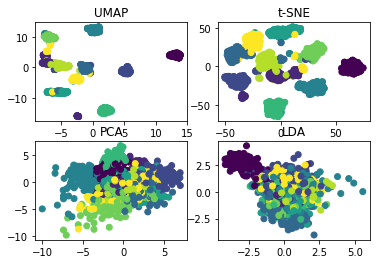

In [38]:
# Plot comparing methods for digits data
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(dig_umap[:,0], dig_umap[:,1], c = y_digits)
ax1.set_title('UMAP')
ax2.scatter(dig_tsne[:,0], dig_tsne[:,1], c = y_digits)
ax2.set_title('t-SNE')
ax3.scatter(dig_pca[:,0], dig_pca[:,1], c = y_digits)
ax3.set_title('PCA')
ax4.scatter(dig_lda[:,0], dig_lda[:,1], c = y_digits)
ax4.set_title('LDA')


Text(0.5, 1.0, 'LDA')

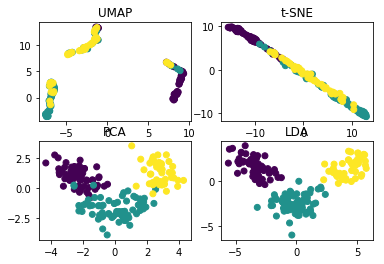

In [39]:
# Plot comparing methods for wine data
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
ax1.scatter(wine_umap[:,0], wine_umap[:,1], c = y_wine)
ax1.set_title('UMAP')
ax2.scatter(wine_tsne[:,0], wine_tsne[:,1], c = y_wine)
ax2.set_title('t-SNE')
ax3.scatter(wine_pca[:,0], wine_pca[:,1], c = y_wine)
ax3.set_title('PCA')
ax4.scatter(wine_lda[:,0], wine_lda[:,1], c = y_wine)
ax4.set_title('LDA')

Comments:

1.Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?

Dimensionality reduction methods can not handle non-standardized data, because it finds components that maximimizes the variance. Thus, if features of the data have different variances, due to different measures, one feature will be considered more important even though it might only be due to the measure. Since the digits data only have features measured in the same units this is not important. However, for the wine data features are measured in different units and it is important to standardize the data. 


2.Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.


The PCA method gives a good result on the wine dataset. The result for the digits dataset is one big cluster, so it is very hard to sepereate the values from another.

The LDA method gives an even better result for the wine data, since the clusters are even more seperable. The result for the digits data is has not improved from the PCA method. 

The t-SNE method gives a very unreadable result for the wine data, whith all the clusters on a linear line. The result for the digits data is much better dividing the data into seperable clusters.

The UMAP method also gives a very unreadable result for the wine data. The result for the digits data give a very good resylt dividing the data into even more seperable clusters.

To sum up we see that linear data analysis (PCA, LDA) is performing very well on the wine dataset but pretty bad on the wine dataset. The non-linear unsupervised methods (t-SNE, UMAP) are however performing very well on the digits data but very poorly on the wine data. 

# Problems from exercise set 4¶
In this problem we will try to implement and understand some of the ideas used in Athey, Imbens (2015) to develop Honest Inference in desicion tree models. The paper begins by covering honesty in a setting of population averages, and for estimating conditional means; so you will need to look towards the second half of the paper to get an impression of it's use for treatment-effect estimation.

Ex. 4.2.1: What does it mean that a tree is honest? In particular what are the implications in terms of

The intuition for why honesty is required in order to get good local treatment effect estimates?
The practical implementation of the DT algorithm?

Solution:

A model is honest if it doesn't use the same information to partition the data into sub-groups, that it does to estimate the treatment effects. Thus the data is split into two parts. The first part is used to built the tree (and apply cross validation). The second part is used to estimate treatment effects within the leafs of the tree. Thus, the honest method can produce unbiased heterogeneous estimates, since biased is usually caused by overfitting when using the same data to built the tree and estimate the effects. Since only the second part is used to estimate treatment effects the leafes are considered exogenous and independent, which is a nessecary assumption for unbiasedness. The honest model can produce unbiased effects despite of having many features and less observations, thus honesty places no restrictions on model complexity. However you will calculate estimatates built on a smaller dataset which will give higher errors. Since estimates are unbiased, cross-validation criteria focus only on the trade-off between smaller leafes and variance within leaves. 

When implementing the algorithm this means that the partition is done on a test sample and the treatment effect is calculated on an estimation sample. Thus when the Mean squarred error is minimized, the expression is both a function of the test sample and the estimation sample. Is is assumed that the test sample and the estimation sample are independent. Second, the cross validation criteria is modified in the algorithm to putting importance of reducing variance within leaves. This is done by using the train sample while considering the estimation sample size. To reduce variance bias the cross validation criteria is further evaluated using only outcomes from the cross validation sample, which is a subset of the train sample.